In [1]:
from perception import hashers
from sklearn.cluster import KMeans

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from src.config import config
from src.phishIRISData import PhishIRISDataset
from src.helpers import formatted_name, compute_accuracy, visualize

hasher = hashers.PHashF()
train_dataset = PhishIRISDataset(
    data_dir=config.PHISHIRIS_DL_DATASET_DIR, split="train", preprocess=False
)

In [2]:
kmeans = KMeans(n_clusters=15, init="k-means++", n_init="auto")
clusters = kmeans.fit(list(train_dataset.img_to_hash.values()))
data_transformed = kmeans.transform(list(train_dataset.img_to_hash.values()))

In [3]:
(
    clusters.labels_[2],
    train_dataset.hash_to_img[
        hasher.vector_to_string(list(train_dataset.img_to_hash.values())[2])
    ],
)

(3, 'apple-(6).png')

### Visualize the clusters

In [ ]:
# Visualize cluster distribution per company
"""
# TODO: wypisz dominujaca klase z kazdego klastra
# dict klasa -> nr klastra
# jakies metryczki z TP, TN, FP, FN i inne z scikit learna
# popraw kod xD

for company, imgs in img_per_company.items():
    predicted_class = np.zeros(shape=(len(imgs)))
    for idx, hash_of_img in enumerate(imgs):
        predicted_class[idx] = int(kmeans.predict([hasher.string_to_vector(hash_of_img)]))
    unique, counts = np.unique(predicted_class, return_counts=True)
    print(f'{company}: ', dict(zip(unique, counts)))
    print('='*10)
    
"""
for company, imgs in train_dataset.img_per_company.items():
    predicted_class = np.zeros(shape=(len(imgs)))
    for idx, hash_of_img in enumerate(imgs):
        predicted_class[idx] = int(
            kmeans.predict([hasher.string_to_vector(hash_of_img)])[0]
        )

    # Get the unique classes and their counts
    unique, counts = np.unique(predicted_class, return_counts=True)

    # Create a bar plot for this company
    plt.figure(figsize=(8, 5))
    plt.bar(unique, counts, color="orange")
    plt.xlabel("Cluster")
    plt.ylabel("Count of Images")
    plt.title(f"Class Distribution for {company}")
    plt.xticks(unique)
    plt.show()

    print(f"{company}: ", dict(zip(unique, counts)))
    print("=" * 10)

In [ ]:
# Visualize company distribution in each cluster
cluster_to_hash = defaultdict(list)
for idx, (img_name, img_hash) in enumerate(train_dataset.img_to_hash.items()):
    cluster_to_hash[kmeans.labels_[idx]].append(hasher.vector_to_string(img_hash))

for idx in range(clusters.n_clusters):
    labels = []
    for x in cluster_to_hash[idx]:
        labels.append(train_dataset.hash_to_company[x])
    unique_labels, label_counts = np.unique(labels, return_counts=True)

    # Create a bar plot for the labels of this company
    plt.figure(figsize=(15, 5))
    plt.bar(unique_labels, label_counts, color="pink")
    plt.xlabel("Labels")
    plt.ylabel("Count of Images")
    plt.title(f"Label Distribution for cluster #{idx}")
    plt.xticks(unique_labels)
    plt.show()

    print(f"Cluster #{idx} Labels: ", dict(zip(unique_labels, label_counts)))
    print("=" * 10)

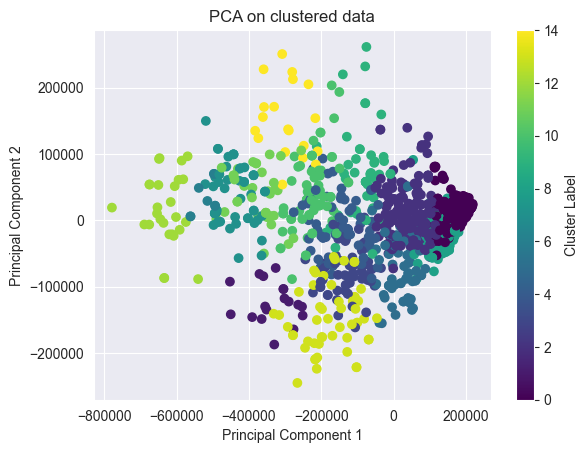

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2 dimensions using PCA
pca = PCA(n_components=2)
data_to_transform = []

for X, label in train_dataset:
    data_to_transform.append(train_dataset.img_to_hash[formatted_name(X)])

pca_data = pca.fit_transform(data_to_transform)

# Visualize the
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters.labels_, cmap="viridis")
plt.title("PCA on clustered data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster Label")
plt.show()

### Get most common class in each cluster

In [3]:
cluster_to_hash = defaultdict(list)
cluster_to_company = defaultdict(list)
for idx, (img_name, img_hash) in enumerate(train_dataset.img_to_hash.items()):
    hsh = hasher.vector_to_string(img_hash)
    cluster_to_hash[kmeans.labels_[idx]].append(hsh)
    cluster_to_company[kmeans.labels_[idx]].append(train_dataset.hash_to_company[hsh])

for cluster_id in cluster_to_company.keys():
    companies, counts = np.unique(cluster_to_company[cluster_id], return_counts=True)
    # get max element from counts and its company
    cluster_to_company[cluster_id] = companies[np.argmax(counts)]

cluster_to_company

defaultdict(list,
            {5: 'facebook',
             3: 'microsoft',
             6: 'other',
             13: 'other',
             0: 'paypal',
             14: 'paypal',
             4: 'other',
             9: 'other',
             2: 'other',
             11: 'other',
             7: 'other',
             1: 'other',
             8: 'other',
             12: 'other',
             10: 'other'})

In [4]:
val_dataset = PhishIRISDataset(
    data_dir=config.PHISHIRIS_DL_DATASET_DIR, split="val", preprocess=False
)

y_pred = [
    # get picture name and change space to '-'
    cluster_to_company[
        clusters.predict([val_dataset.img_to_hash[formatted_name(X)]])[0]
    ]
    for X, label in val_dataset
]
y_true = [label for _, label in val_dataset]

# Compute accuracy
compute_accuracy(y_true, y_pred)

acc:			59.38921
balanced_acc:	13.85236


(0.5938921377517868, 0.1385236455919673)

In [5]:
from sklearn.metrics import classification_report
import numpy as np

print(
    classification_report(
        y_true, y_pred, target_names=np.unique([label for _, label in train_dataset])
    )
)

              precision    recall  f1-score   support

       adobe       0.00      0.00      0.00        27
     alibaba       0.00      0.00      0.00        26
      amazon       0.00      0.00      0.00        11
       apple       0.00      0.00      0.00        15
         boa       0.00      0.00      0.00        35
       chase       0.00      0.00      0.00        37
         dhl       0.00      0.00      0.00        42
     dropbox       0.00      0.00      0.00        40
    facebook       0.19      0.40      0.25        57
    linkedin       0.00      0.00      0.00        14
   microsoft       0.32      0.19      0.24        53
       other       0.80      0.82      0.81      1000
      paypal       0.18      0.67      0.28        93
  wellsfargo       0.00      0.00      0.00        45
       yahoo       0.00      0.00      0.00        44

    accuracy                           0.59      1539
   macro avg       0.10      0.14      0.11      1539
weighted avg       0.55   

/Users/marcinjarczewski/src/phish-target-recognition/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcinjarczewski/src/phish-target-recognition/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marcinjarczewski/src/phish-target-recognition/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

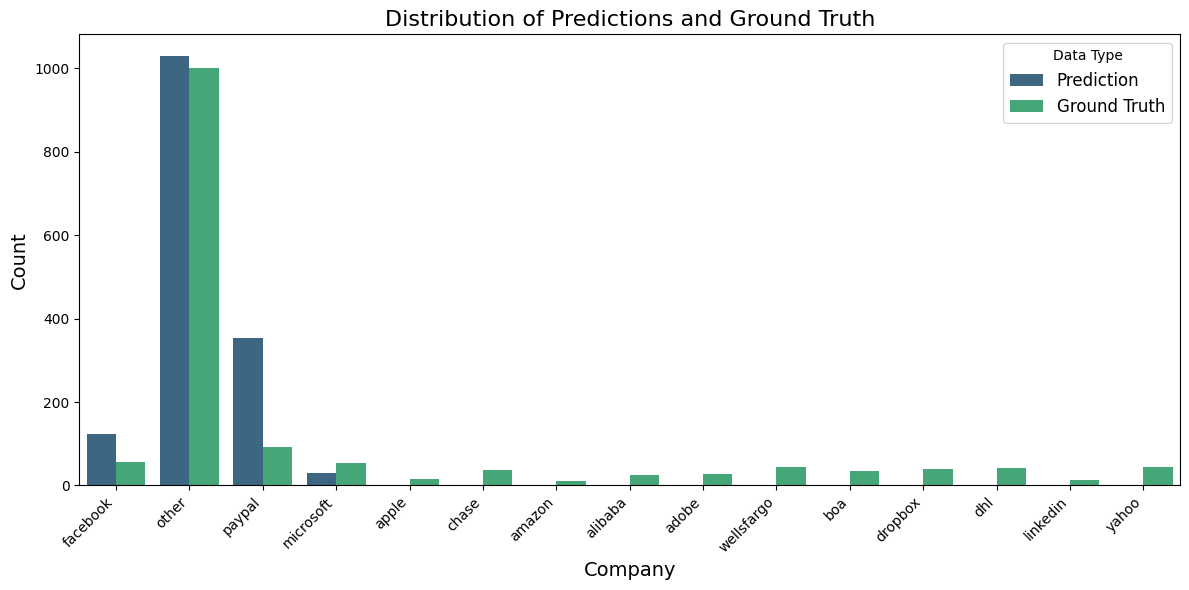

In [6]:
data = visualize(y_true, y_pred)

In [7]:
data[data["Type"] == "Prediction"]["Company"].value_counts()

Company
other        963
paypal       409
facebook     127
microsoft     40
Name: count, dtype: int64

In [8]:
data[data["Type"] == "Ground Truth"]["Company"].value_counts()

Company
other         1000
paypal          93
facebook        57
microsoft       53
wellsfargo      45
yahoo           44
dhl             42
dropbox         40
chase           37
boa             35
adobe           27
alibaba         26
apple           15
linkedin        14
amazon          11
Name: count, dtype: int64